In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
import os
import shutil
import splitfolders
from PIL import Image
from keras.models import Sequential

# Skin Cancer MNIST: HAM10000 - Exploratory data analysis & Skin lesion classification

Author: Filip Sosnowski

Dataset: [Skin Cancer MNIST: HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

##### Importing metadata

### 1. Exploratory data analysis

In [3]:
df = pd.read_csv("data/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


There are 10015 entries in this dataset. Each of the columns is of type object, besides 'age' (which is of type float64). It's also the only column, that contains null data.

In [5]:
df.shape[1], df.columns.tolist()

(7, ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'])

There are 7 attributes in the metadata:
- lesion_id - unique identifier assigned to each lesion
- image_id - unique identifier assigned to each dermatoscopic image
- dx - diagnostic categories pigmented lesions
- dx_type - type of pigmented lesion
- age - age of a patient
- sex - gender of a patient
- localization - where the pigmented lesion is located

In [6]:
len(df['dx'].unique()), df['dx'].unique()

(7, array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object))

There are 7 diagnostic categories pigmented lesions:
- bkl - benign keratosis-like lesions
- nv - melanocytic nevi
- df - dermatofibroma
- mel - melanoma
- vasc - vascular lesions
- bcc - basal cell carcinoma
- akiec - actinic keratoses and intraepithelial carcinoma / Bowen's disease

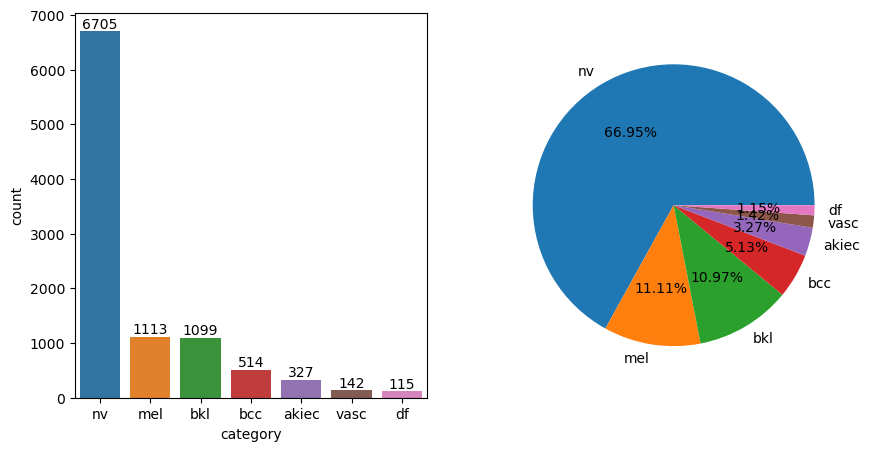

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(x=df['dx'].rename('category'), order=df['dx'].value_counts().index)
ax1.bar_label(ax1.containers[0])
plt.subplot(1,2,2)
plt.pie(x=df['dx'].value_counts(), labels=df['dx'].value_counts().index, autopct='%.2f%%')
plt.show()

We can see that there are way more records for 'nv' than in each of other categories. The dataset is imbalanced - it will be dealt with later.

In [8]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are 57 null values in 'age' column. I replaced the nulls with mean value of records in this column.

In [9]:
df['age'].fillna((df['age'].mean()), inplace=True)
df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

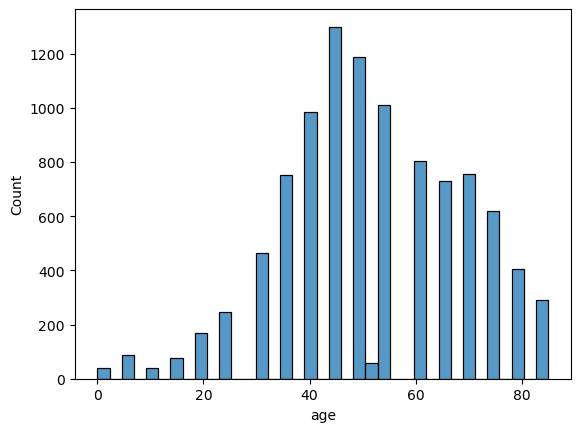

In [10]:
sns.histplot(data=df, x='age')

Most images come from patients who are between 40 and 60 years old. Below, I showed population pyramid for this data.

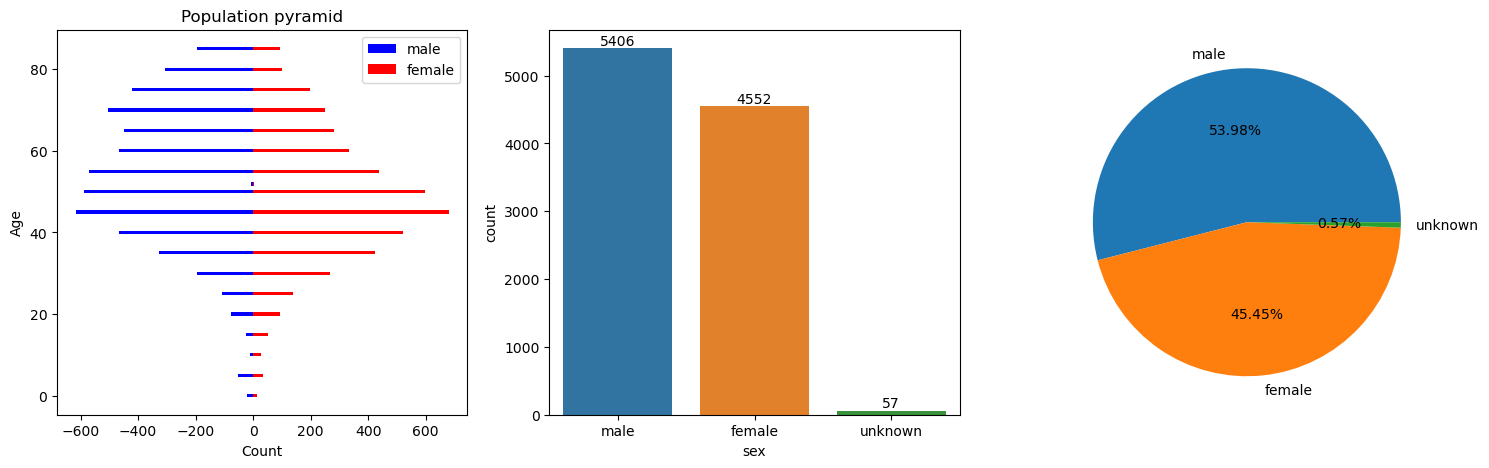

In [11]:
age_counts = df.groupby(['sex', 'age']).size()
age_counts_df = pd.DataFrame({'age': age_counts.index.get_level_values('age'),
                              'sex': age_counts.index.get_level_values('sex'),
                              'count': age_counts.values})

male_counts = age_counts_df[age_counts_df['sex'] == 'male']
female_counts = age_counts_df[age_counts_df['sex'] == 'female']
male_counts = male_counts.iloc[::-1]

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.barh(male_counts['age'], -male_counts['count'], height=0.8, align='center', color='blue')
plt.barh(female_counts['age'], female_counts['count'], height=0.8, align='center', color='red')
plt.xlabel('Count')
plt.ylabel('Age')
plt.title('Population pyramid')
plt.legend(['male', 'female'])
plt.subplot(1,3,2)
ax = sns.countplot(x=df['sex'], order=df['sex'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.subplot(1,3,3)
plt.pie(x=df['sex'].value_counts(), labels=df['sex'].value_counts().index, autopct='%.2f%%')
plt.show()

There are 854 more male entries than female entries. Also, for 57 of all the records, the gender is unknown.

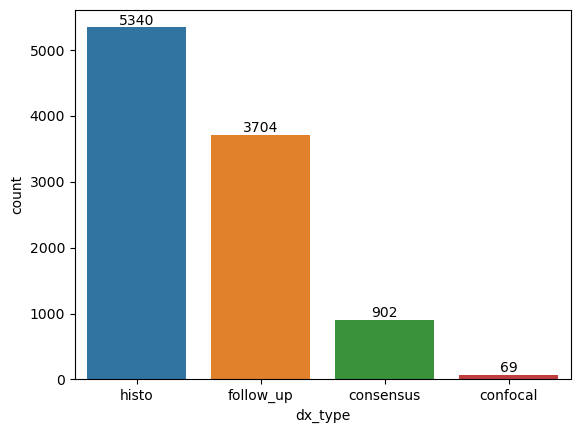

In [12]:
ax = sns.countplot(x=df['dx_type'], order=df['dx_type'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

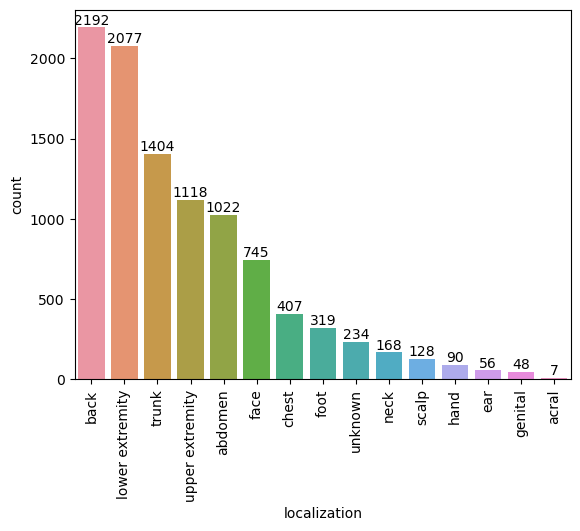

In [13]:
ax = sns.countplot(x=df['localization'], order=df['localization'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

### 2. Skin lesion classification

In [14]:
num_of_unique_lesions = len(df['lesion_id'].value_counts())
num_of_unique_lesions, df.shape[0] - num_of_unique_lesions


(7470, 2545)

There are 7470 different skin lesions in the dataset, which means that 2545 of 10015 images are duplicates or they are similiar to different image of exact same lesion for a patient.

I decided to delete the duplicates from dataset:

In [15]:
df = df.drop_duplicates(subset=['lesion_id'])

In [16]:
labels = df["dx"].unique()
labels

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [17]:
original_dir = os.getcwd() + "/data/HAM10000_images/"
classes_dir = os.getcwd() + "/data/HAM10000_images_organized/"
split_dir = os.getcwd() + "/data/HAM10000_images_split/"

In [18]:
if os.path.exists(classes_dir):
    shutil.rmtree(classes_dir)
if os.path.exists(split_dir):
    shutil.rmtree(split_dir)

os.makedirs(classes_dir)
os.makedirs(split_dir)

Then I put images into adequate folders based on category name (e.g. /bkl):

In [19]:
for label in labels:
    os.makedirs(classes_dir + str(label) + '/', exist_ok=True)
    for image_id in df[df['dx'] == label]['image_id']:
        shutil.copyfile((original_dir + image_id + ".jpg"),(classes_dir + label + "/" + image_id + ".jpg"))

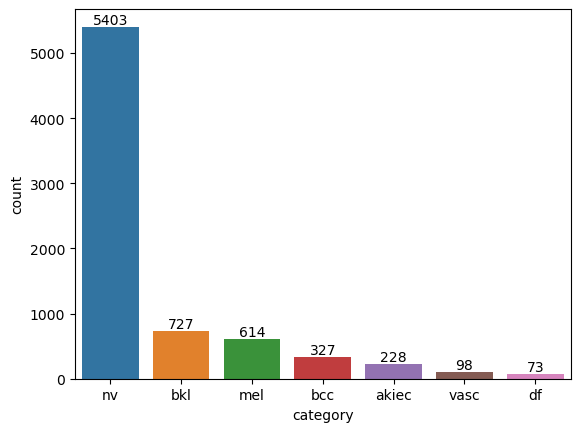

In [20]:
ax = sns.countplot(x=df['dx'].rename('category'), order=df['dx'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

I decided to remove some photos to make the dataset more balanced.

In [21]:
dir_to_delete_from = classes_dir + "nv/"
jpg_files = [file for file in os.listdir(dir_to_delete_from) if file.endswith(".jpg")]
random.shuffle(jpg_files)
files_to_delete = 4_600
for i in range(files_to_delete):
    file_to_delete = os.path.join(dir_to_delete_from, jpg_files[i])
    os.remove(file_to_delete)

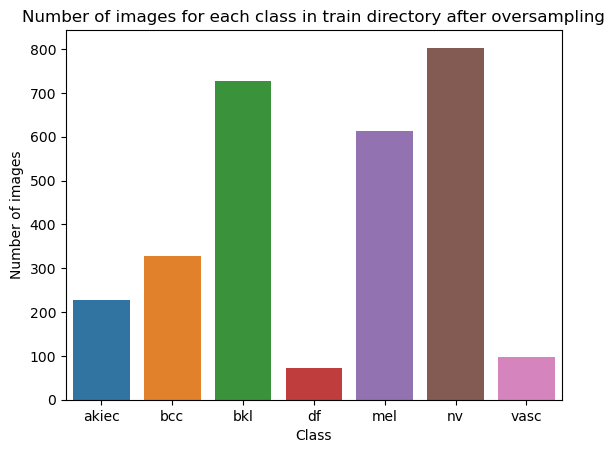

In [22]:
subdirs = [name for name in os.listdir(classes_dir) if os.path.isdir(os.path.join(classes_dir, name))]
subdir_names = []
file_counts = []

for subdir in subdirs:
    subdir_path = os.path.join(classes_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    subdir_names.append(subdir)
    file_counts.append(file_count)

ax = sns.barplot(x=subdir_names, y=file_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images for each class in train directory after oversampling')
plt.show()

Splitting images into three directories: train, test, validation

In [23]:
splitfolders.ratio(classes_dir, output=split_dir, seed=1337, ratio=(.8, .1, .1))

Copying files: 2870 files [00:12, 224.54 files/s]


In [24]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,         # rescale pixel values to [0, 1]
    rotation_range=10,      # random rotation between 0 and 10 degrees
    width_shift_range=0.1,  # random horizontal shift
    height_shift_range=0.1, # random vertical shift
    horizontal_flip=True,   # random horizontal flip
    vertical_flip=False,    # no random vertical flip
    fill_mode='nearest'     # fill gaps with nearest pixel
)

In [25]:
parent_directory = split_dir + "train/"
os.listdir(parent_directory)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [26]:
max_samples = 0
for folder_name in os.listdir(parent_directory):
    folder_path = os.path.join(parent_directory, folder_name)
    images_in_dir = len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    if(max_samples < images_in_dir):
        max_samples = images_in_dir

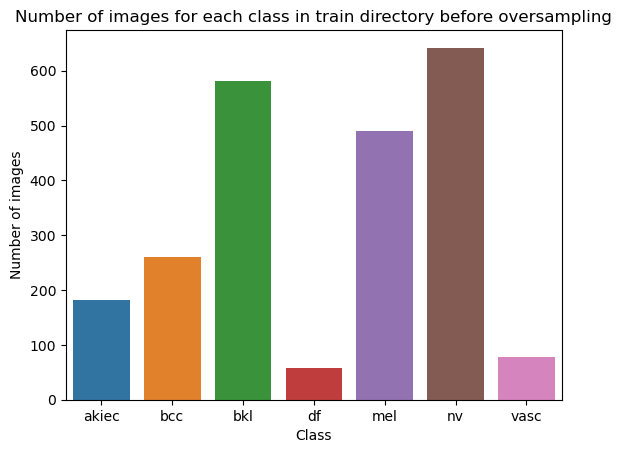

In [27]:
train_dir = split_dir + "train/"
subdirs = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
subdir_names = []
file_counts = []

for subdir in subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    subdir_names.append(subdir)
    file_counts.append(file_count)

ax = sns.barplot(x=subdir_names, y=file_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images for each class in train directory before oversampling')
plt.show()

Generating augmented images to balance dataset

In [28]:
train_dir = split_dir + "train/"

for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)
    images_in_dir = len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    if (images_in_dir != max_samples):
        num_of_images_needed = max_samples - images_in_dir
        augmented_images_per_original = num_of_images_needed // images_in_dir

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            img_array = np.array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=folder_path, save_prefix='aug_', save_format='jpg'):
                i += 1
                if i >= augmented_images_per_original:
                    break

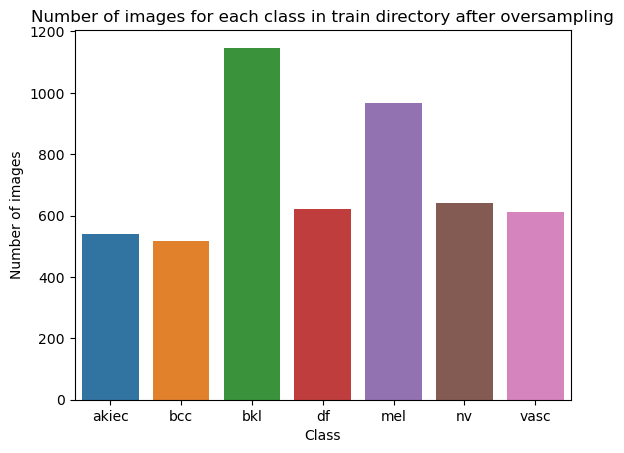

In [29]:
train_dir = split_dir + "train/"
subdirs = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
subdir_names = []
file_counts = []

for subdir in subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    subdir_names.append(subdir)
    file_counts.append(file_count)

ax = sns.barplot(x=subdir_names, y=file_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images for each class in train directory after oversampling')
plt.show()

In [30]:
train = ImageDataGenerator(rescale=1/255)
val = ImageDataGenerator(rescale=1/255)

train_dir = split_dir + "train/"
val_dir = split_dir + "val/"

train_data = train.flow_from_directory(directory=train_dir,
                                       target_size=(200,200),
                                       batch_size=16
                                       )
val_data = val.flow_from_directory(directory=val_dir,
                                       target_size=(200,200),
                                       batch_size=16
                                    )

Found 5045 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


In [31]:
train_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [32]:
train_data.samples
train_data.batch_size

16

Convolutional neural network (CNN)

In [33]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

input_shape = train_data.image_shape
num_classes = 7
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

In [34]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

In [36]:
model_fit = model.fit(train_data, steps_per_epoch=train_data.samples//train_data.batch_size, validation_data=val_data, epochs=25, callbacks=[earlystopping])

Epoch 1/25
315/315 [==============================] - 534s 2s/step - loss: 1.8758 - accuracy: 0.2609 - val_loss: 1.7735 - val_accuracy: 0.3251
Epoch 2/25
315/315 [==============================] - 567s 2s/step - loss: 1.6925 - accuracy: 0.3309 - val_loss: 1.5359 - val_accuracy: 0.4028
Epoch 3/25
315/315 [==============================] - 533s 2s/step - loss: 1.6040 - accuracy: 0.3671 - val_loss: 1.4652 - val_accuracy: 0.4417
Epoch 4/25
315/315 [==============================] - 490s 2s/step - loss: 1.5118 - accuracy: 0.4062 - val_loss: 1.4287 - val_accuracy: 0.4629
Epoch 5/25
315/315 [==============================] - 501s 2s/step - loss: 1.4581 - accuracy: 0.4323 - val_loss: 1.3810 - val_accuracy: 0.4417
Epoch 6/25
315/315 [==============================] - 510s 2s/step - loss: 1.4059 - accuracy: 0.4353 - val_loss: 1.3124 - val_accuracy: 0.4876
Epoch 7/25
315/315 [==============================] - 510s 2s/step - loss: 1.3480 - accuracy: 0.4649 - val_loss: 1.3525 - val_accuracy: 0.4841

In [37]:
model.save(filepath="model/model.h5")

Evaluation

In [50]:
test = ImageDataGenerator(rescale=1/255)

test_dir = split_dir + "test/"

test_data = train.flow_from_directory(directory=test_dir,
                                       target_size=(200,200),
                                       batch_size=16
                                       )
loss_test, accuracy_test = model.evaluate(test_data)
print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy_test, loss_test))

Found 294 images belonging to 7 classes.


19/19 [==============================] - 5s 250ms/step - loss: 1.2539 - accuracy: 0.5136
Test: accuracy = 0.513605  ;  loss_v = 1.253901
